In [1]:
import numpy as np

from data import Data
from dataset import Dataset
from clusterizer import Clusterizer
from trainer import Trainer

In [2]:
data = Data()

Files reading...
File: training_30


  0%|          | 9/5518 [00:00<01:03, 86.87it/s]

Targets calculating...


100%|██████████| 5518/5518 [01:02<00:00, 87.85it/s] 


In [3]:
LEN_SUBSEQ = 30

dataset = Dataset(data, 220, LEN_SUBSEQ, batch_size=16)

100%|██████████| 5518/5518 [00:03<00:00, 1563.70it/s]


Data size: 5518


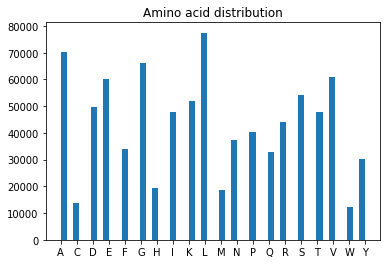

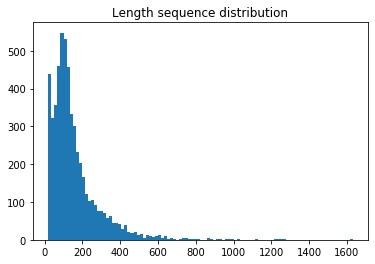

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

print('Data size:', len(data.seqs))


### AAs

plt.hist(sorted([a for aa in data.seqs for a in aa]), bins=50);
plt.title('Amino acid distribution')
plt.show()

plt.hist([len(aa) for aa in data.seqs], bins=100);
plt.title('Length sequence distribution')
plt.show()

Data size: 11173


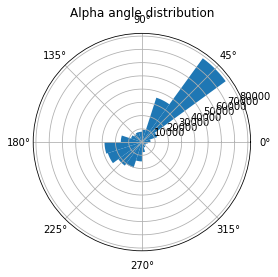

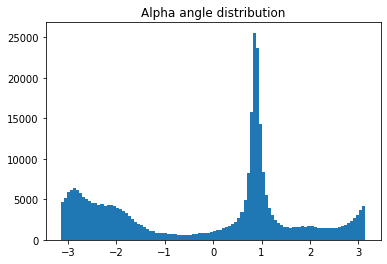

In [5]:
train_dataset = dataset.train_data_features

print('Data size:', len(train_dataset[0]))


### Alpha angles

train_alphas = np.array([a for aa in train_dataset[2] for a in aa])

plt.subplot(111, polar=True).hist(train_alphas, bins=20);
plt.title('Alpha angle distribution')
plt.show()

plt.hist(train_alphas, bins=100);
plt.title('Alpha angle distribution')
plt.show()

In [6]:
clusterizer = Clusterizer(dataset, n_clusters=2)

Class 0: 156292 elements
Class 1: 167725 elements


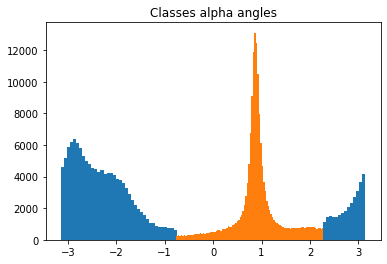

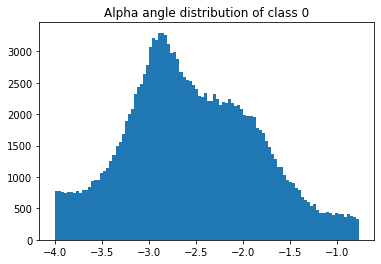

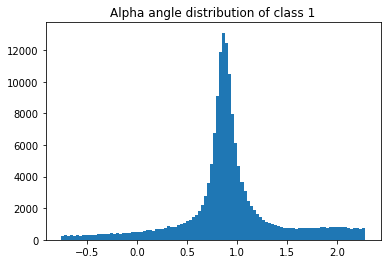

In [7]:
print('Class 0: %d elements' % clusterizer.angle_class_idxs[0].sum())
print('Class 1: %d elements' % clusterizer.angle_class_idxs[1].sum())


plt.hist(clusterizer.angle_class[0], bins=100);
plt.hist(clusterizer.angle_class[1], bins=100);
plt.title('Classes alpha angles')
plt.show()
    
plt.hist(np.append(clusterizer.angle_class[0][clusterizer.angle_class[0] < 0], clusterizer.angle_class[0][clusterizer.angle_class[0] > 0] - 2 * np.pi), bins=100);
plt.title('Alpha angle distribution of class 0')
plt.show()

plt.hist(clusterizer.angle_class[1], bins=100);
plt.title('Alpha angle distribution of class 1')
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvModel(nn.Module):
    def __init__(self, len_subseq, n_class=2):
        super(ConvModel, self).__init__()
        
        self.n_class = n_class
        
        seq = (len_subseq, 20)
        pssm = (21, len_subseq)
                
        self.seq = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),

            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.1),
            
            nn.Flatten(),
            nn.Linear(1024, (len_subseq - 1) * n_class)
        )
         
        
    def forward(self, seq, pssm):
        batch_size = seq.shape[0]
        
        pssm = torch.transpose(pssm, dim0=1, dim1=2)
        
        features = torch.cat([seq, pssm], dim=-1).unsqueeze(1)

        out = self.seq(features).view(-1, self.n_class)
        
        return F.softmax(out, dim=-1)

In [ ]:
class UnetModel(nn.Module):
    def __init__(self, len_subseq, n_class=2):
        super(UnetModel, self).__init__()

        self.n_class = n_class
        
        seq = (len_subseq, 20)
        pssm = (21, len_subseq)
        analysis = (1, 12)
                
        self.a_linear = nn.Linear(analysis[1], len_subseq)

        self.pool = nn.MaxPool1d(2)

        self.conv1 = nn.Conv1d(len_subseq, 16, 3)
        self.conv2 = nn.Conv1d(16, 32, 3)
        self.conv3 = nn.Conv1d(32, 64, 3)

        self.conv4 = nn.Conv1d(64, 128, 3)

        self.deconv1 = nn.Conv1d(128, 64, 3)
        self.deconv2 = nn.Conv1d(64, 32, 3)
        self.deconv3 = nn.Conv1d(32, 16, 3)
        self.deconv4 = nn.Conv1d(16, 16, 3)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(16 * ((seq[1] + pssm[0]) * 2 - 6), (len_subseq - 1) * n_class)
        

    def forward(self, seq, pssm, analysis):
        batch_size = seq.shape[0]
        
        pssm = torch.transpose(pssm, dim0=1, dim1=2)
        analysis = self.a_linear(analysis).view(batch_size, -1, 1)

        features = torch.cat([seq, pssm], dim=-1)

        conv1 = self.conv1(features)
        pool1 = self.pool(F.relu(conv1))
        
        conv2 = self.conv2(pool1)
        conv2 = F.dropout(conv2, 0.1)
        pool2 = self.pool(F.relu(conv2))

        conv3 = self.conv3(pool2)
        conv3 = F.dropout(conv3, 0.1)
        pool3 = self.pool(F.relu(conv3))

        conv4 = self.conv4(pool3)

        deconv1 = self.deconv1(F.interpolate(conv4, size=conv3.shape[-1]+2))
        cat1 = torch.cat([conv3, deconv1], dim=-1)

        deconv2 = self.deconv2(F.interpolate(cat1, size=conv2.shape[-1]+2))
        cat2 = torch.cat([conv2, deconv2], dim=-1)
        
        deconv3 = self.deconv3(F.interpolate(cat2, size=conv1.shape[-1]+2))
        cat3 = torch.cat([conv1, deconv3], dim=-1)

        deconv4 = self.deconv4(F.relu(cat3))

        out  = self.fc(self.flatten(deconv4)).view(-1, self.n_class)
        
        return F.softmax(out, dim=-1)

In [9]:
class RecModel(nn.Module):
    def __init__(self, len_subseq, n_class=2):
        super(RecModel, self).__init__()
        
        self.n_class = n_class

        seq = (len_subseq, 20)
        pssm = (21, len_subseq)
        
        hidden_size = 512

        self.bilstm1 = nn.LSTM(input_size=seq[1] + pssm[0],
                               hidden_size=hidden_size // 2,
                               bidirectional=True,
                               batch_first=True)
            
        self.bilstm2 = nn.LSTM(input_size=hidden_size,
                               hidden_size=hidden_size // 4,
                               bidirectional=True,
                               batch_first=True,
                               dropout=0.1)
            
        self.bilstm3 = nn.LSTM(input_size=hidden_size // 2,
                               hidden_size=hidden_size // 8,
                               bidirectional=True,
                               batch_first=True,
                               dropout=0.1)
            
        self.bilstm4 = nn.LSTM(input_size=hidden_size // 4,
                               hidden_size=hidden_size // 16,
                               bidirectional=True,
                               batch_first=True,
                               dropout=0.1)
        
        self.bilstm5 = nn.LSTM(input_size=hidden_size // 8,
                               hidden_size=hidden_size // 32,
                               bidirectional=True,
                               batch_first=True,
                               dropout=0.1)
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(len_subseq * hidden_size // 16, (len_subseq - 1) * n_class)


    def forward(self, seq, pssm):
        batch_size = seq.shape[0]
        
        pssm = torch.transpose(pssm, dim0=1, dim1=2)

        features = torch.cat([seq, pssm], dim=-1)

        bilstm, _ = self.bilstm1(features)
        bilstm, _ = self.bilstm2(bilstm)
        bilstm, _ = self.bilstm3(bilstm)
        bilstm, _ = self.bilstm4(bilstm)
        bilstm_out, _ = self.bilstm5(bilstm)

        out  = self.fc(self.flatten(bilstm_out)).view(-1, self.n_class)
        
        return F.softmax(out, dim=-1)

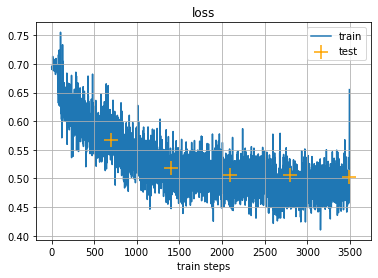

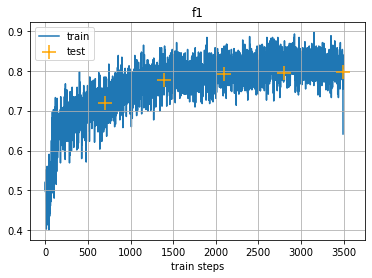

Epoch: 5, val loss: 0.5022592085503763, val f1: 0.7969445216907675


In [10]:
trainer = Trainer(RecModel(LEN_SUBSEQ, n_class=2), dataset, clusterizer)
trainer.train(n_epochs=5)

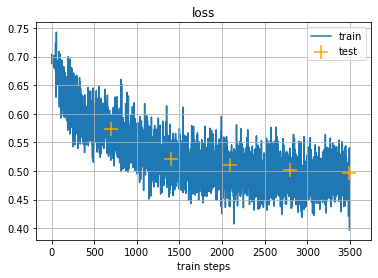

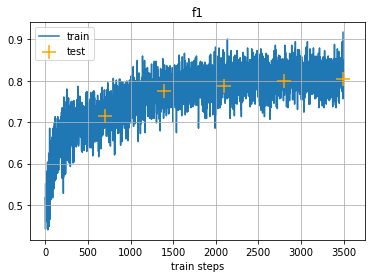

Epoch: 5, val loss: 0.4960297151438652, val f1: 0.8031493325917686


In [10]:
trainer = Trainer(RecModel(LEN_SUBSEQ, n_class=2), dataset, clusterizer)
trainer.train(n_epochs=5)